In [1]:
"""Importing basic modules for analysis"""
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 20)
%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
"""Read the raw Telecom churn data in the dataframe"""
telco_churn = pd.read_csv(r'C:\Users\Kurtesy\Downloads\Upgrad\telecom_churn_data.csv', encoding='ISO-8859-1')
print(telco_churn.head(10))
telco_churn.shape

   mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   
5     7000286308        109             0.0             0.0             0.0   
6     7001051193        109             0.0             0.0             0.0   
7     7000701601        109             0.0             0.0             0.0   
8     7001524846        109             0.0             0.0             0.0   
9     7001864400        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/20

(99999, 226)

In [3]:
"""Fetch the relevant dataset - Prepaid recharge data for usage analysis
   Data pack recharge and Topup recharge - (data, num)
   Analyse for 3 months 6th, 7th and 8th, validate the accuracy for 9th month customer churn.
"""
recharges = ['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 
             'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 
             'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9']

In [4]:
"""Derive the columns for the recharge done data + num"""
telco_churn['total_rech_amt_all_6'] = telco_churn['total_rech_amt_6'] +  telco_churn['total_rech_data_6']  * telco_churn['av_rech_amt_data_6']
telco_churn['total_rech_amt_all_7'] = telco_churn['total_rech_amt_7'] + telco_churn['total_rech_data_7']  * telco_churn['av_rech_amt_data_7']
telco_churn['total_rech_amt_all_8'] = telco_churn['total_rech_amt_8'] + telco_churn['total_rech_data_8']  * telco_churn['av_rech_amt_data_8']
#For churn score
telco_churn['total_rech_amt_all_9'] = telco_churn['total_rech_amt_9'] + telco_churn['total_rech_data_9']  * telco_churn['av_rech_amt_data_9']
telco_churn.shape

(99999, 230)

In [5]:
"""Data Cleaning and Unwantned column Removal"""
"""Remove data with Low Variance, threshold = 2"""
good_variance_cols = [key for key, val in telco_churn.nunique().to_dict().items() if val > 2]
telco_churn = telco_churn[good_variance_cols]
telco_churn.shape

(99999, 206)

In [6]:
"""Drop columns used in derived columns"""
other_cols = ['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9',
              'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 
              'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',]
telco_churn.drop(other_cols, axis=1, inplace=True)
telco_churn.shape

(99999, 194)

In [7]:
"""Drop columns with missing value either na or 0 values (null cleaning)"""
"""Threshold = 25%"""
"""NOTE: skipping 9th month for Churn Score Analysis"""
misses = telco_churn.isnull().sum() * 100 / len(telco_churn)
missing_value_df = pd.DataFrame({'col': telco_churn.columns,
                                 'misses': misses})

misses_col = missing_value_df.loc[(missing_value_df["col"].str.contains('_9')==False) & 
                                (missing_value_df["misses"] > 25.0) &
                                  (missing_value_df["col"].str.contains('total_rech_amt_all')==False)]["col"]
print(misses_col)
telco_churn.drop(misses_col, axis=1, inplace=True)
telco_churn.shape

date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
Name: col, dtype: object


(99999, 176)

In [8]:
"""Column Type and Naming Standardization"""
datatypes = telco_churn.dtypes
obj_cols = datatypes[datatypes=='object']
print(obj_cols)
#datetime.datetime conversion
for col in obj_cols.index:
    telco_churn[col] = pd.to_datetime(telco_churn[col])
telco_churn.head(1)

date_of_last_rech_6         object
date_of_last_rech_7         object
date_of_last_rech_8         object
date_of_last_rech_9         object
date_of_last_rech_data_9    object
dtype: object


,mobile_number,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,...,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_9,max_rech_data_9,count_rech_2g_9,count_rech_3g_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_9,arpu_2g_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_all_6,total_rech_amt_all_7,total_rech_amt_all_8,total_rech_amt_all_9
0,7000842753,197.385,214.816,213.803,21.1,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,...,252,252,0,2014-06-21,2014-07-16,2014-08-08,2014-09-28,252,252,252,0,NaT,NaN,NaN,NaN,30.13,1.32,5.75,0.0,83.57,150.76,109.61,0.0,NaN,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,968,30.4,0.0,101.2,3.58,614.0,504.0,504.0,NaN


In [9]:
"""Since the month refernace to each column is tandardised to numeric gregorian sequence,
    lets refer the months in all coumns in same fashion
    6-jun
    7-jul
    8-aug
    9-sept
"""
#Rename
telco_churn.rename(columns={'jun_vbc_3g': 'vbc_3g_6', 
                            'jul_vbc_3g': 'vbc_3g_7', 
                            'aug_vbc_3g': 'vbc_3g_8',
                            'sep_vbc_3g': 'vbc_3g_9'}, inplace=True)
telco_churn.head(1)

,mobile_number,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,...,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_9,max_rech_data_9,count_rech_2g_9,count_rech_3g_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_9,arpu_2g_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9,total_rech_amt_all_6,total_rech_amt_all_7,total_rech_amt_all_8,total_rech_amt_all_9
0,7000842753,197.385,214.816,213.803,21.1,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,...,252,252,0,2014-06-21,2014-07-16,2014-08-08,2014-09-28,252,252,252,0,NaT,NaN,NaN,NaN,30.13,1.32,5.75,0.0,83.57,150.76,109.61,0.0,NaN,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,968,30.4,0.0,101.2,3.58,614.0,504.0,504.0,NaN


In [10]:
"""Drop Highly Correlated Columns for dimension reduction and simplicity"""
# Create correlation matrix
corr = telco_churn.corr().abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
corr =  corr.stack()
# Find index of feature columns with correlation greater than 0.95
high_corr_drop_cols = [column for column in upper.columns if any(upper[column] > 0.65)]
#high_corr_drop_cols
high_corr_drop_cols = corr[(corr > 0.65) & (corr != 1.0)].sort_values()

In [11]:
corr_drop_cols = set(filter(lambda x: 'loc' in x or 'std' in x or 'date' in x, list(high_corr_drop_cols.reset_index()['level_0'])))
print(corr_drop_cols, len(corr_drop_cols))
telco_churn.drop(corr_drop_cols, axis=1, inplace=True)
telco_churn.shape

{'loc_ic_t2m_mou_6', 'std_ic_mou_8', 'loc_ic_t2t_mou_7', 'std_ic_mou_6', 'loc_og_mou_8', 'loc_ic_t2f_mou_7', 'std_og_t2t_mou_8', 'std_ic_t2m_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_8', 'loc_og_mou_7', 'loc_og_t2m_mou_7', 'std_og_t2f_mou_9', 'loc_ic_t2m_mou_7', 'std_ic_t2t_mou_7', 'loc_og_t2t_mou_8', 'std_ic_t2t_mou_8', 'std_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'std_og_t2t_mou_9', 'std_og_mou_8', 'std_og_mou_9', 'loc_ic_mou_7', 'std_og_t2m_mou_6', 'loc_ic_t2f_mou_6', 'std_ic_t2t_mou_6', 'std_og_t2m_mou_8', 'loc_og_t2t_mou_9', 'loc_ic_t2t_mou_6', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_9', 'loc_og_t2f_mou_7', 'std_ic_t2m_mou_6', 'std_og_t2f_mou_8', 'std_og_t2t_mou_6', 'std_og_t2f_mou_7', 'std_ic_t2m_mou_9', 'loc_og_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_9', 'std_ic_mou_7', 'std_ic_t2m_mou_8', 'std_og_t2f_mou_6', 'loc_ic_mou_9', 'loc_og_mou_9', 'loc_og_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2f_mou_9', 'std_og_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_ic_mou_8', 'std_og_t2m_mou

(99999, 112)

In [12]:
telco_churn.head()
"""Lets get high-value customers using Prepaid Services"""
"""As stated in the Problem statement Those who have recharged with an amount more than or equal to X,
where X is the 70th percentile of the average recharge amount in the first two months are high-value customers"""

avg_amt = (telco_churn["total_rech_amt_all_6"].fillna(0) + telco_churn["total_rech_amt_all_7"].fillna(0))/2.0

#70th Percentile of Avg Recharge Amount
percentile_amt_70 = np.percentile(avg_amt, 70.0)
print('70th percentile of the average recharge amount in the first two months are high-value customers: ', percentile_amt_70)

main_cust_churn = telco_churn[avg_amt >= percentile_amt_70]
print(main_cust_churn.shape)

70th percentile of the average recharge amount in the first two months are high-value customers:  121.8
(30000, 112)


In [13]:
"""Now in order to evaluate our Prediction accuracy, we will define the Dependent Parameter
   CHURN, which is denoted using:
   1 - Customer churns
   0 - Customer does not churns
   For 9th month(Septemner)
Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet 
even once in the churn phase.
"""
churn_tag_cols = ['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']
main_cust_churn['churn'] = np.where(main_cust_churn[churn_tag_cols].sum(axis=1) == 0, 1, 0)
main_cust_churn[churn_tag_cols+['churn']].head(10)

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9,churn
0,0.00,0.00,0.00,0.00,1
1,188.04,72.11,0.00,0.00,0
4,205.31,104.59,0.00,0.00,0
8,34.91,142.18,0.00,0.00,0
9,412.63,151.33,0.00,0.00,0
19,50.38,25.31,0.00,0.00,0
23,127.48,127.63,13.93,314.74,0
26,5.16,5.89,1527.99,0.00,0
32,0.00,0.00,0.00,0.00,1
33,114.16,1.70,30.92,5588.11,0


In [14]:
"""Removing September related features"""
sept_cols = [col for col in main_cust_churn.columns if '_9' in col]
print(sept_cols)
main_cust_churn.drop(sept_cols, axis=1, inplace=True)
main_cust_churn.shape

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2c_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'vbc_3g_9', 'total_rech_amt_all_9']


(30000, 81)

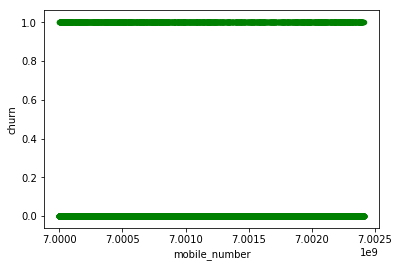

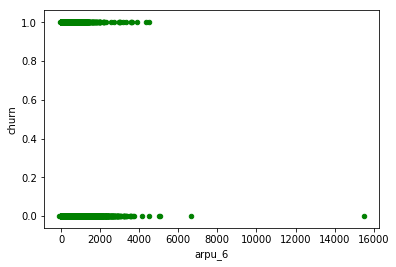

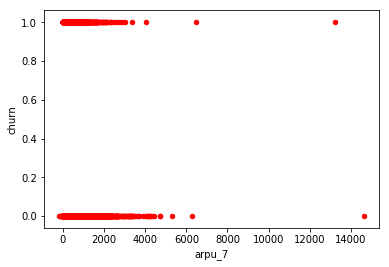

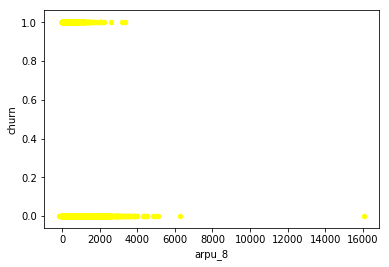

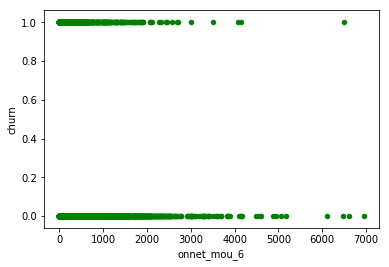

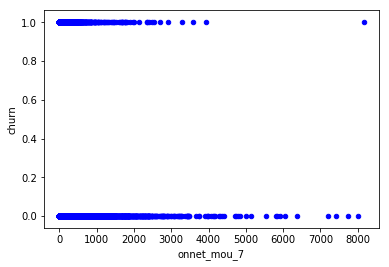

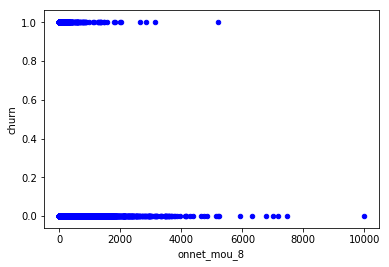

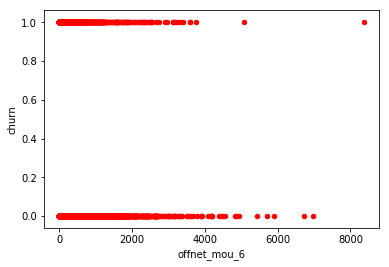

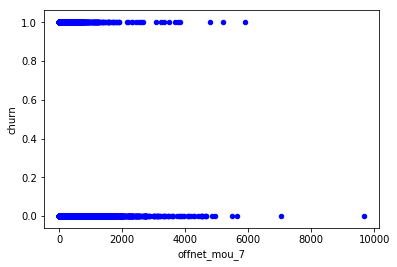

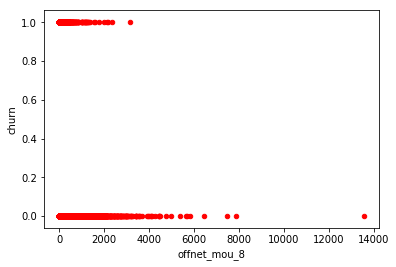

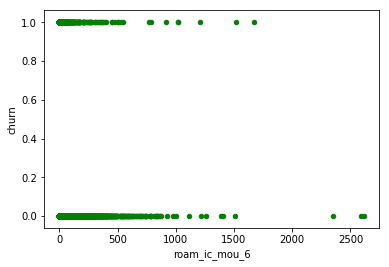

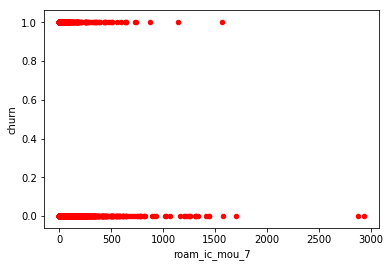

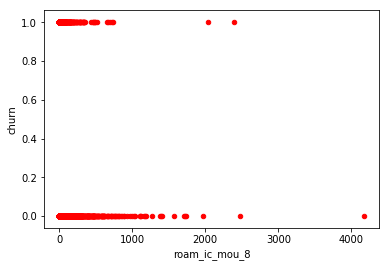

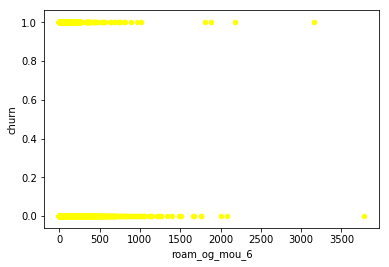

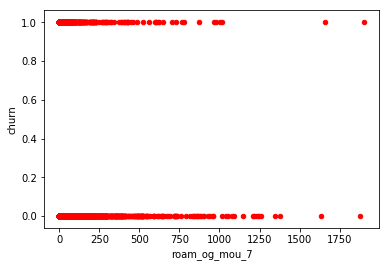

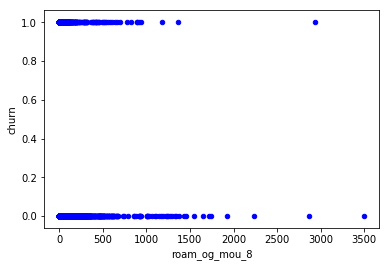

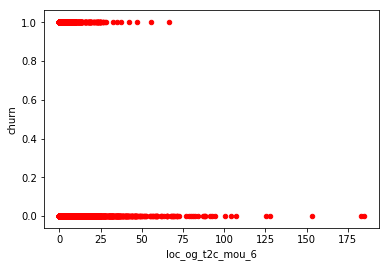

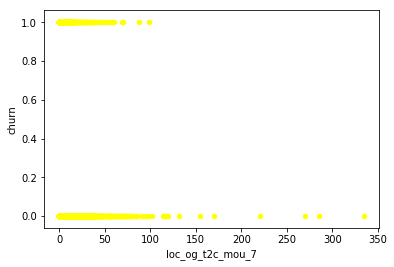

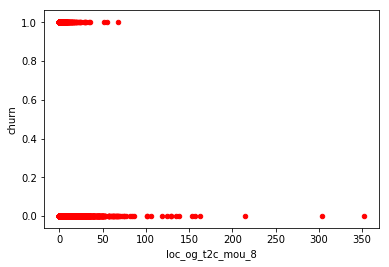

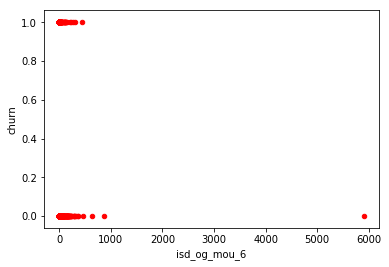

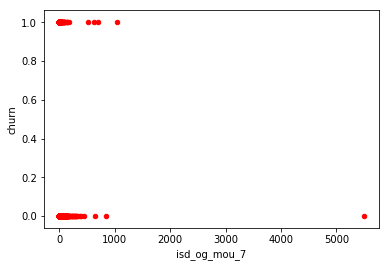

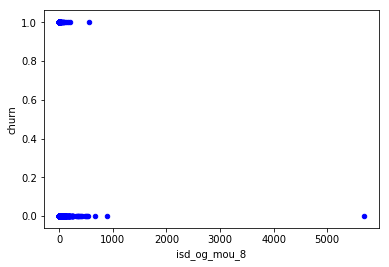

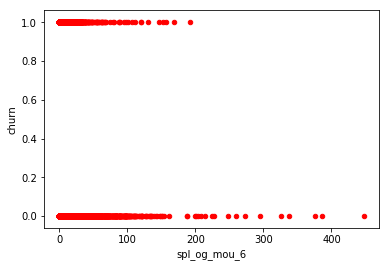

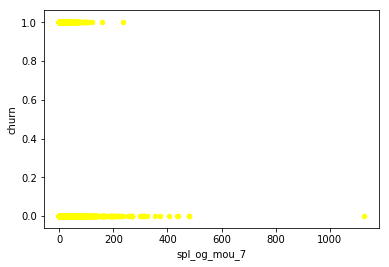

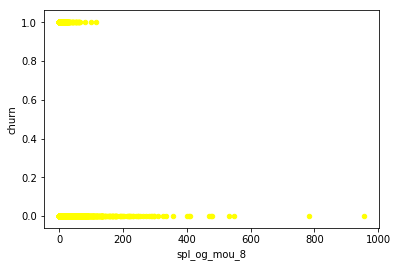

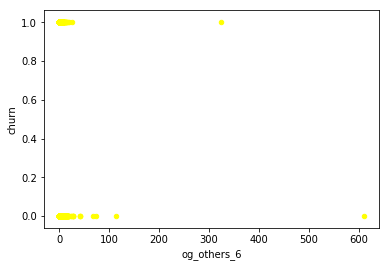

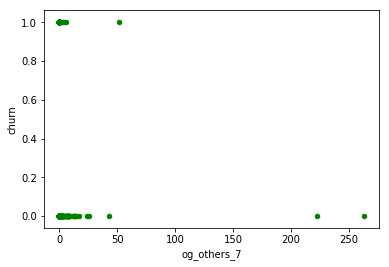

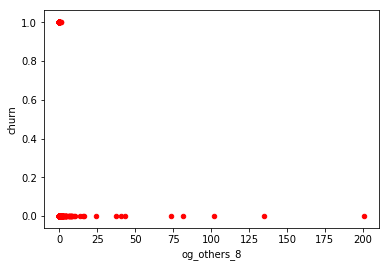

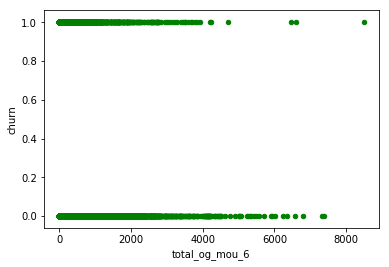

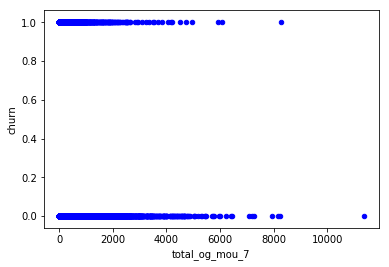

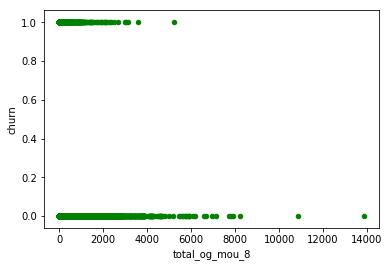

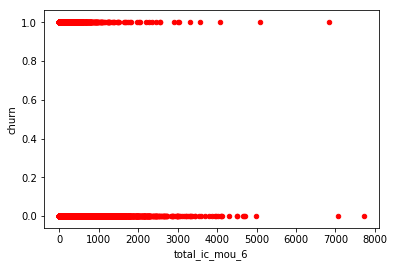

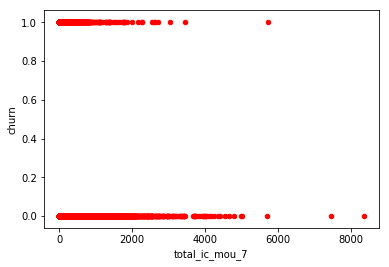

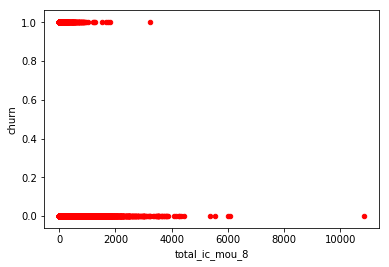

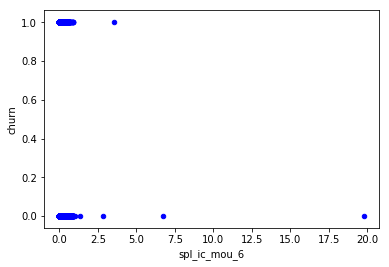

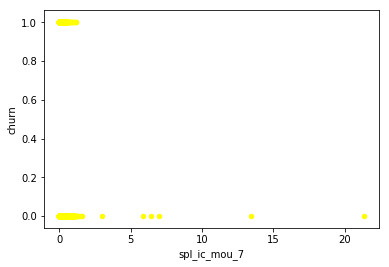

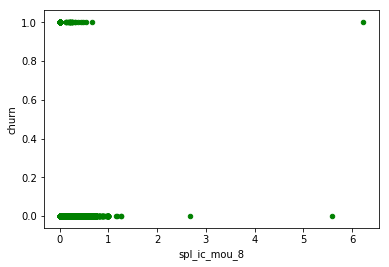

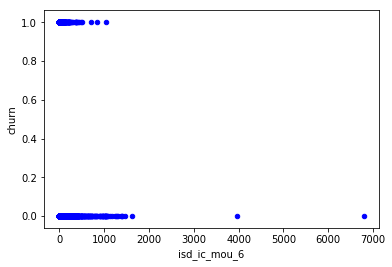

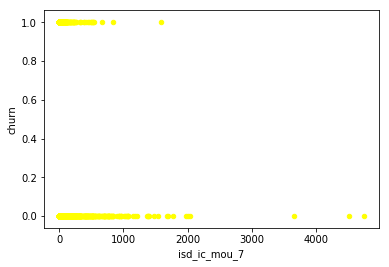

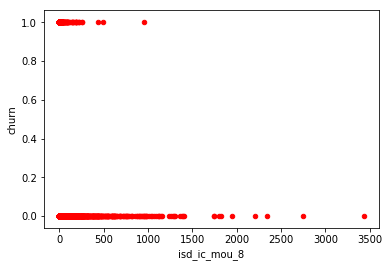

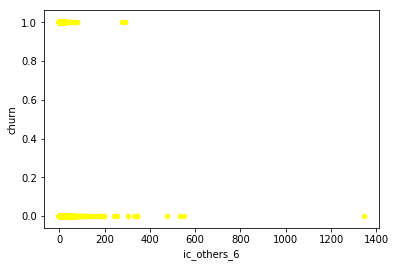

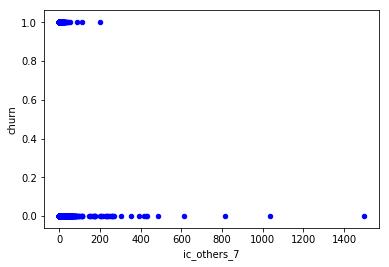

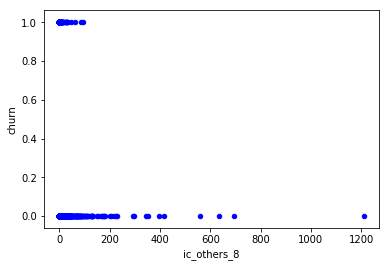

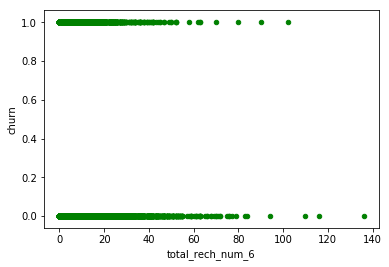

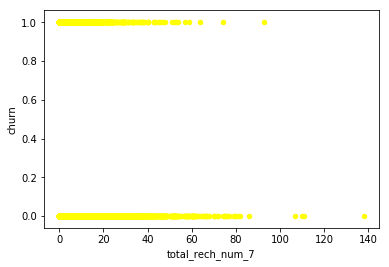

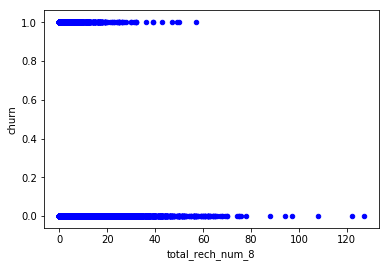

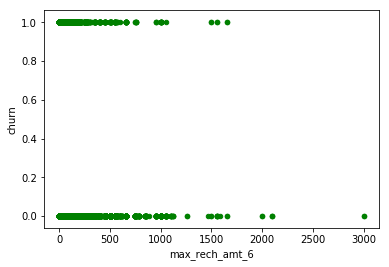

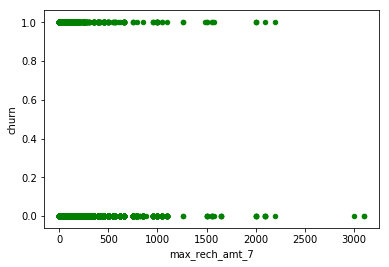

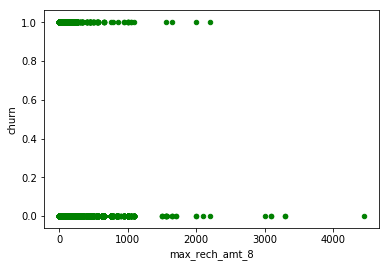

date_of_last_rech_6 column not valid for plot
date_of_last_rech_7 column not valid for plot
date_of_last_rech_8 column not valid for plot


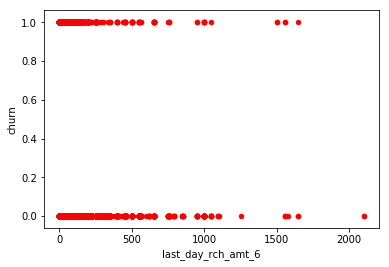

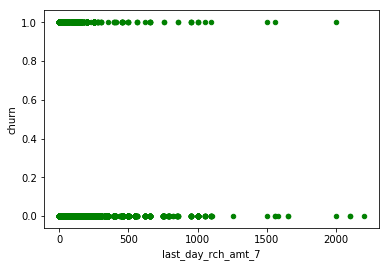

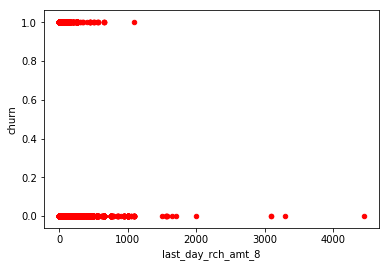

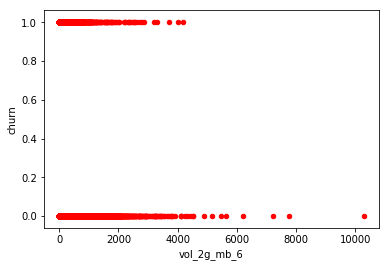

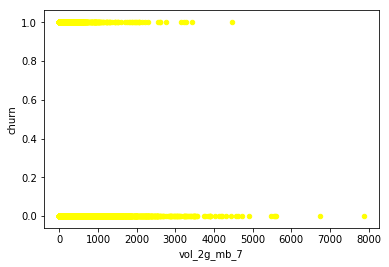

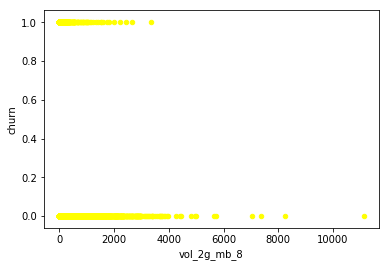

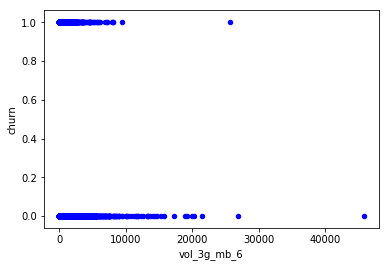

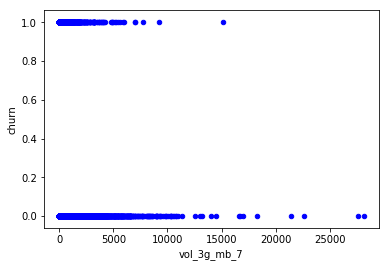

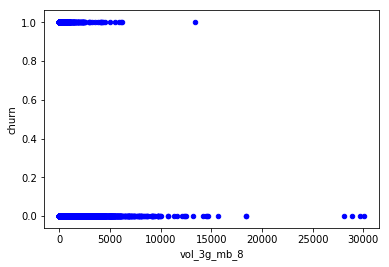

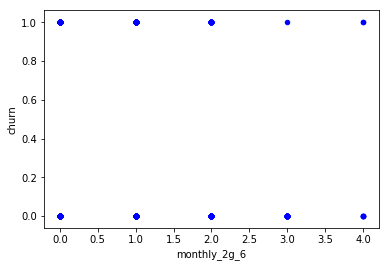

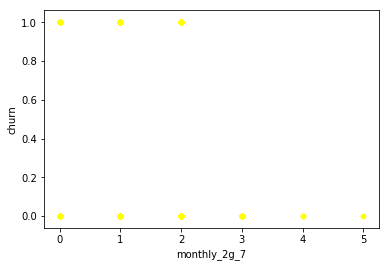

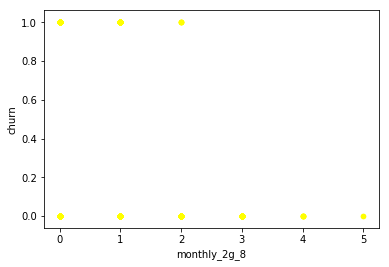

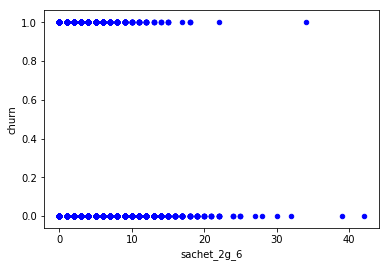

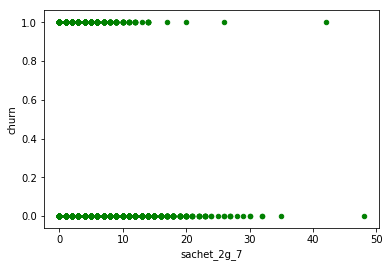

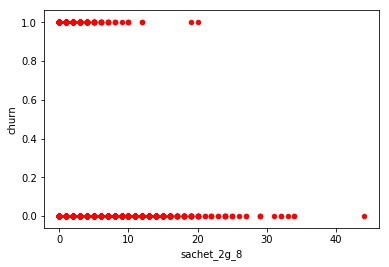

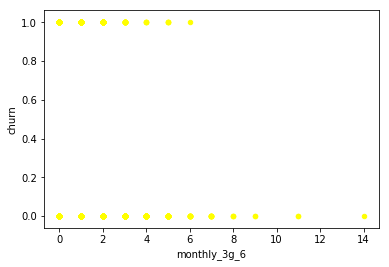

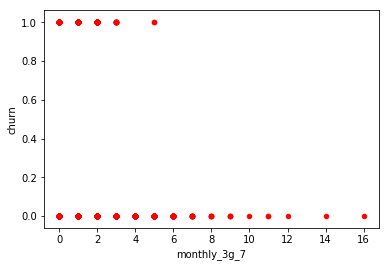

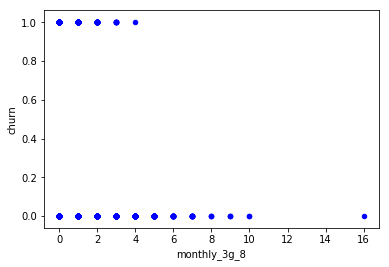

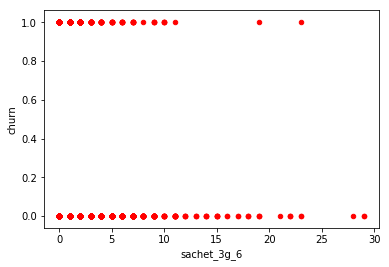

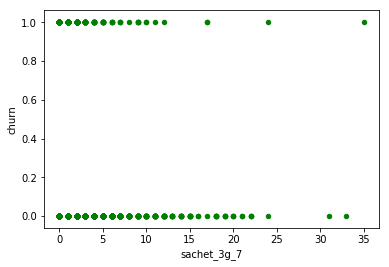

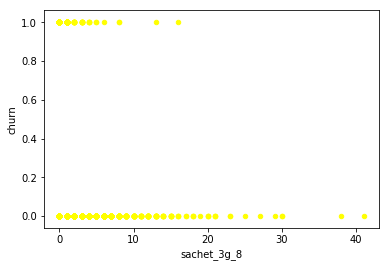

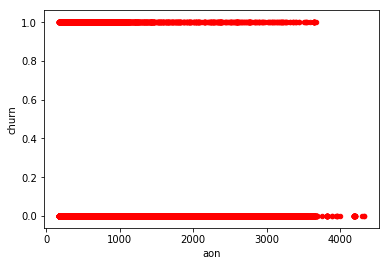

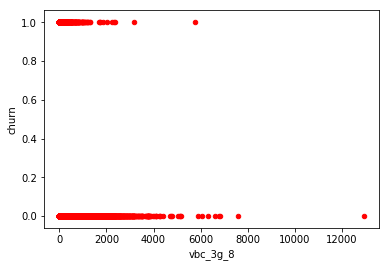

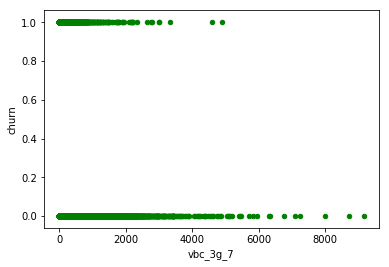

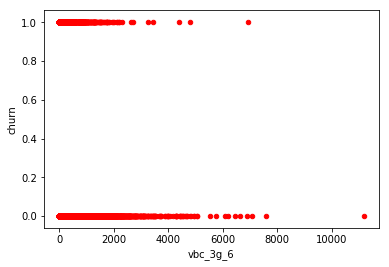

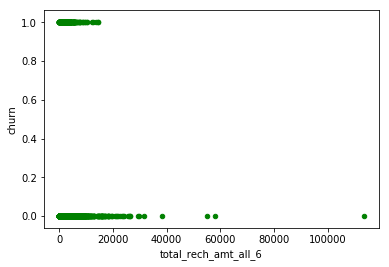

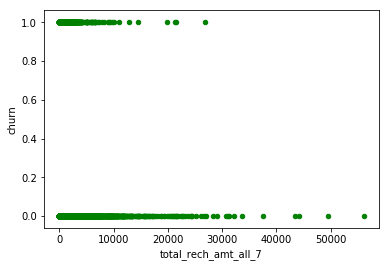

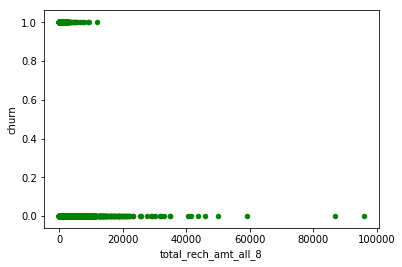

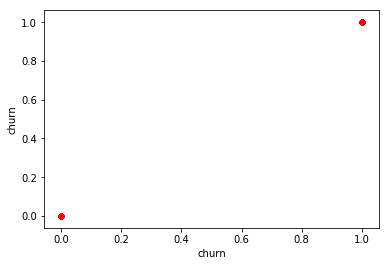

In [15]:
"""Data Analysis to find the best parameter for prediction
plotting data with independent variable as other parameters and churn as dependent variables
Exploratory Data Analysis (EDA)
"""
#Columns
colors = ['red', 'blue', 'green', 'yellow']
for col in main_cust_churn.columns:
    try:
        main_cust_churn.plot(kind='scatter',x=col,y='churn',color=random.choice(colors))
        plt.show()
    except Exception as error:
        print('{0} column not valid for plot'.format(col))

In [16]:
"""As per the Customer behaviour analysis
   The initail 2 months; 6th and 7th are - "Good" phase
   The later 8th month isn - "Action" phase
   And the deciding "churn" phase is the 9th month, which we are predicting
Hence lets add some meaning mertics using mean quantities and amounts in 6th and 7th month.
"""
good_cols = list(filter(lambda x:'_6' in x or '_7' in x, main_cust_churn.columns))
print (good_cols)
unique_good_cols = map(lambda x:x.replace('_6', ''), good_cols)
unique_good_cols = set(map(lambda x:x.replace('_7', ''), unique_good_cols))
print (main_cust_churn.shape)

for col in unique_good_cols:
    print(col)
    if 'date' in col:continue
    avg_col_name = "avg_"+col+"_good"
    col_6 = col+"_6"
    col_7 = col+"_7"
    main_cust_churn[avg_col_name] = (main_cust_churn[col_6]  + main_cust_churn[col_7])/ 2
main_cust_churn.shape

['arpu_6', 'arpu_7', 'onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6', 'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6', 'roam_og_mou_7', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'isd_og_mou_6', 'isd_og_mou_7', 'spl_og_mou_6', 'spl_og_mou_7', 'og_others_6', 'og_others_7', 'total_og_mou_6', 'total_og_mou_7', 'total_ic_mou_6', 'total_ic_mou_7', 'spl_ic_mou_6', 'spl_ic_mou_7', 'isd_ic_mou_6', 'isd_ic_mou_7', 'ic_others_6', 'ic_others_7', 'total_rech_num_6', 'total_rech_num_7', 'max_rech_amt_6', 'max_rech_amt_7', 'date_of_last_rech_6', 'date_of_last_rech_7', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_3g_mb_6', 'vol_3g_mb_7', 'monthly_2g_6', 'monthly_2g_7', 'sachet_2g_6', 'sachet_2g_7', 'monthly_3g_6', 'monthly_3g_7', 'sachet_3g_6', 'sachet_3g_7', 'vbc_3g_7', 'vbc_3g_6', 'total_rech_amt_all_6', 'total_rech_amt_all_7']
(30000, 81)
max_rech_amt
roam_og_mou
vol_2g_mb
total_og_mou
loc_og_t2c_mou
spl_og_mou
spl_ic_mou
monthly_3g
onnet_mou
ic_others

(30000, 106)

In [17]:
"""Removing good colums, since we got better mean metrics"""
main_cust_churn.drop(good_cols, axis=1, inplace=True)
main_cust_churn.shape

(30000, 54)

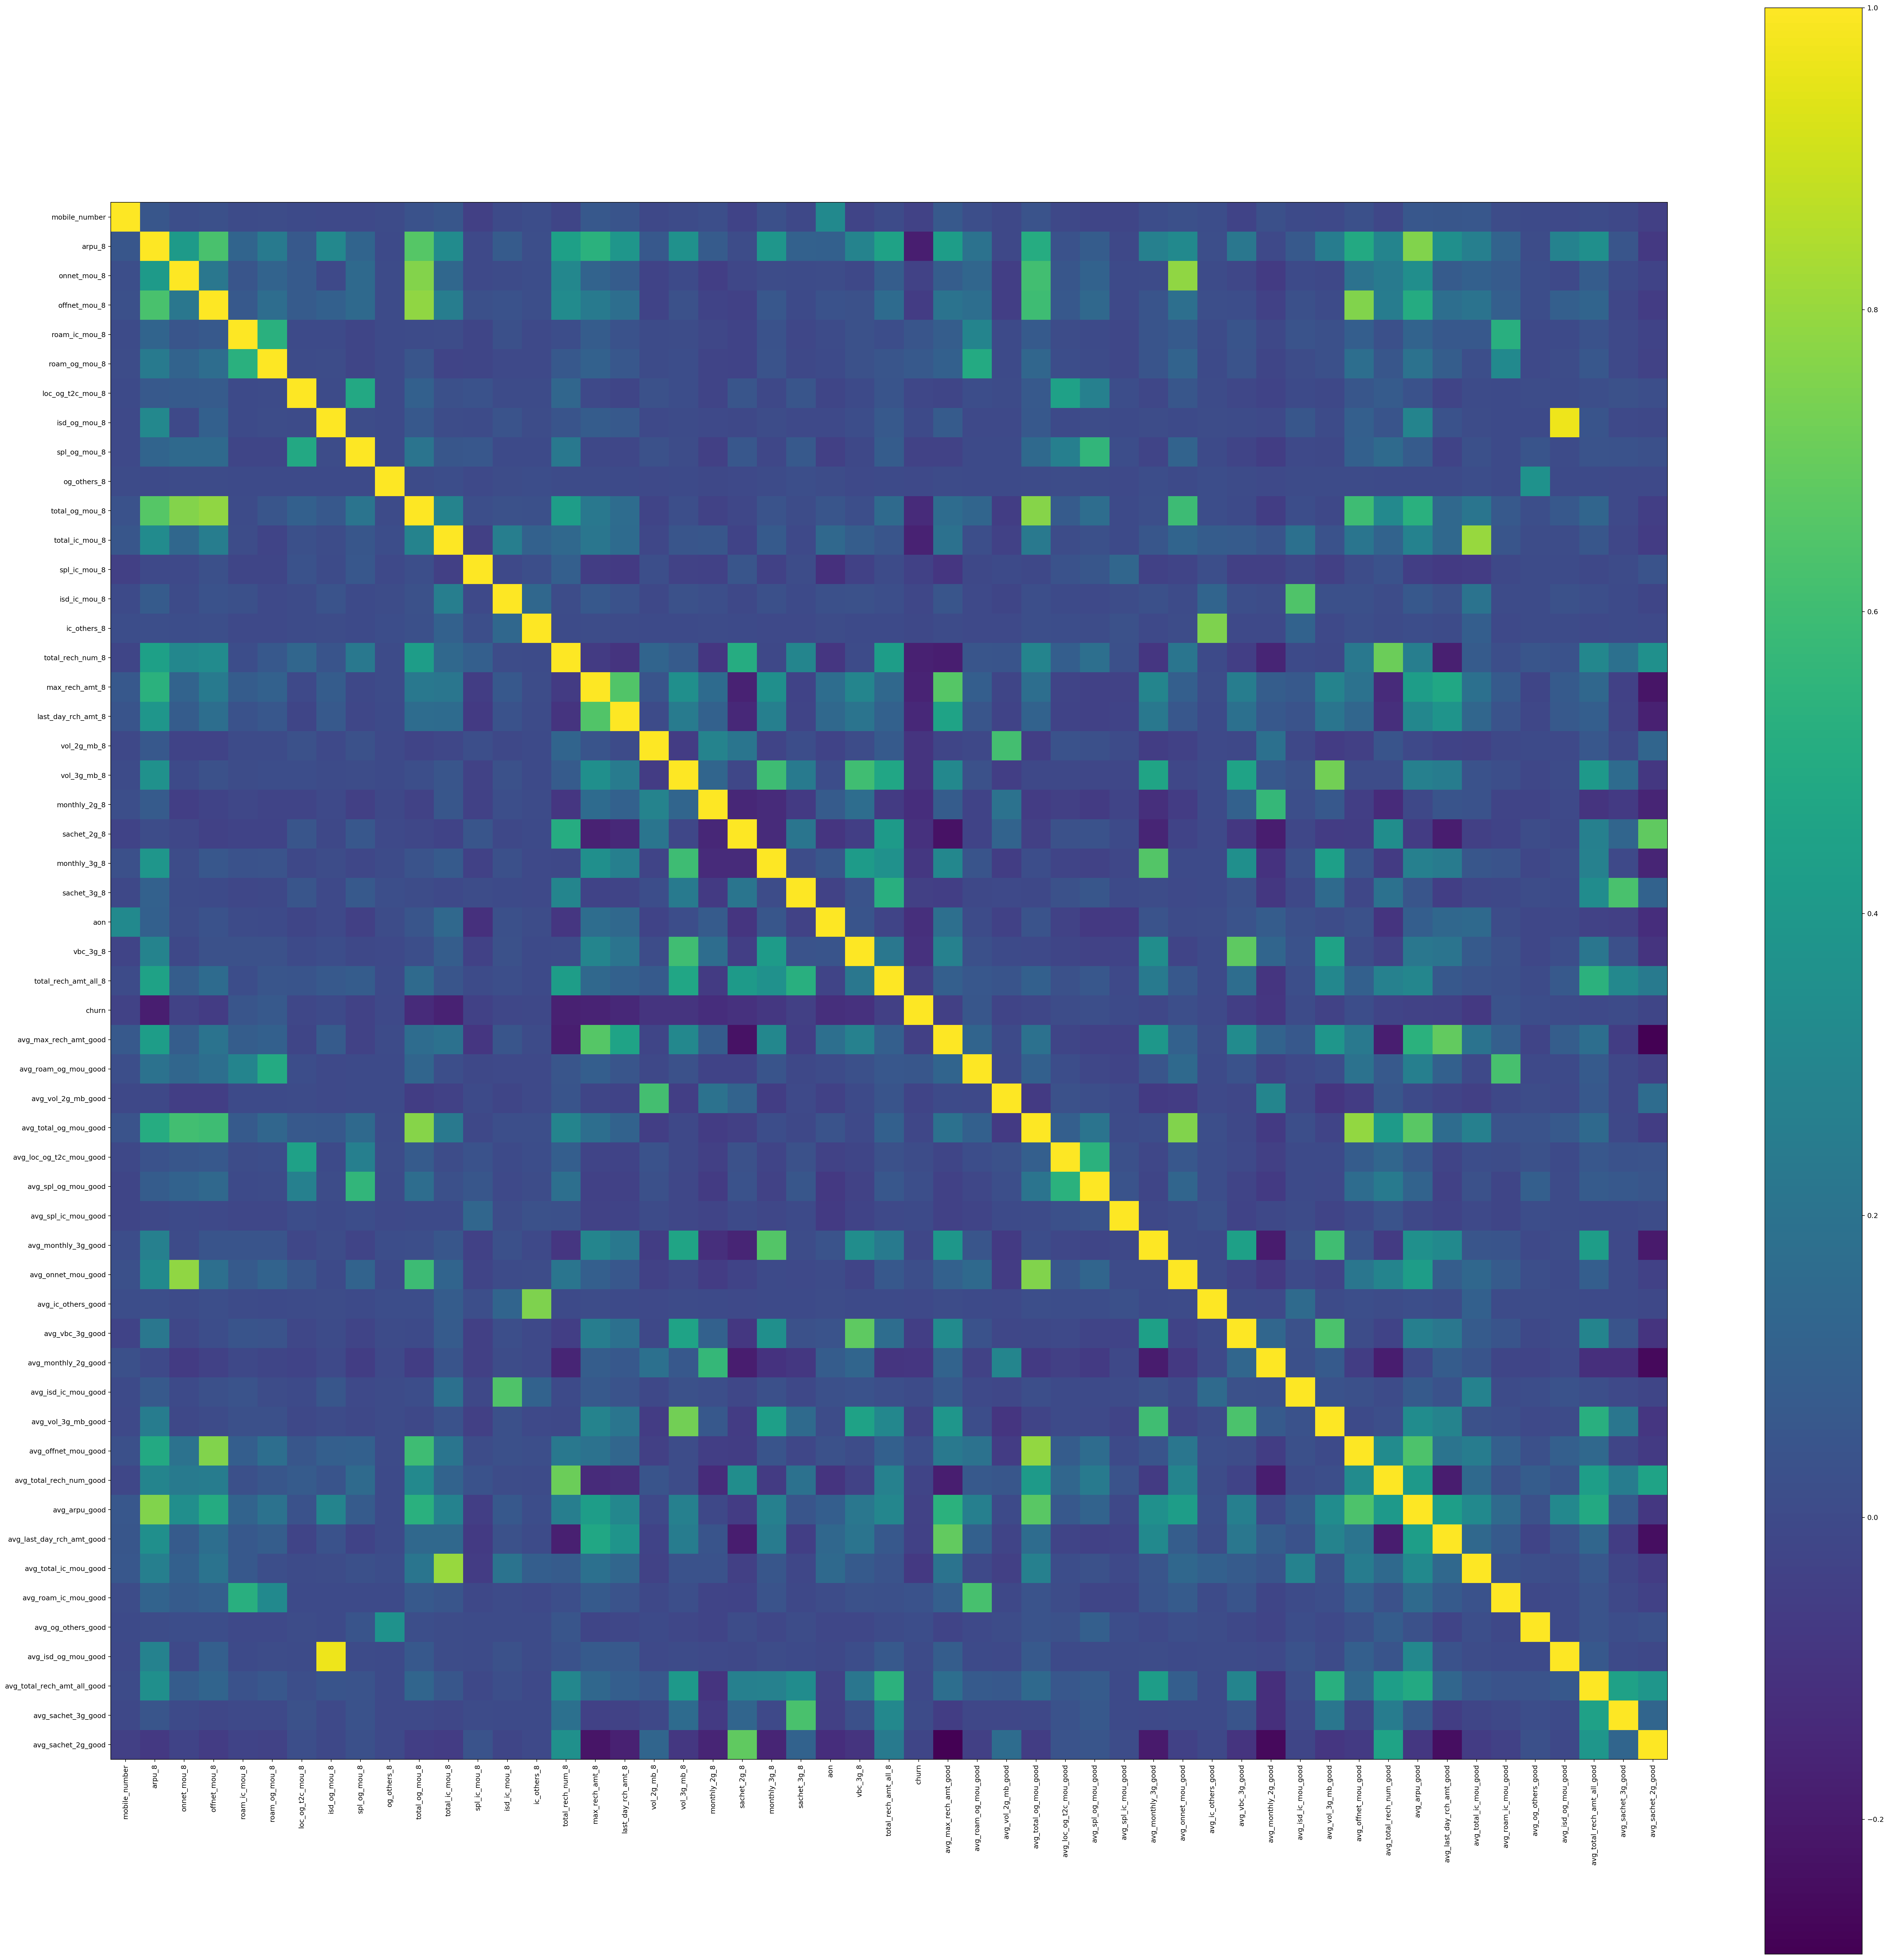

In [18]:
"""Performing EDA and Data analysis on high values customers"""
# Correlation matrix on the features available
corr = main_cust_churn.corr()
plt.figure(num=None, figsize=(50, 50), dpi=180, facecolor='w', edgecolor='w')
corr_matrix = plt.matshow(corr, fignum = 1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(corr_matrix)
plt.show()

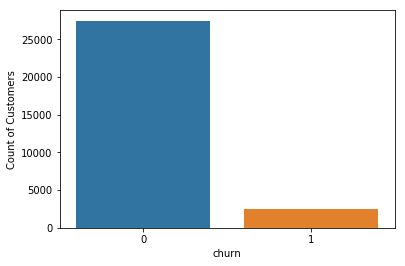

In [19]:
#Churn Distribution
total_cust = len(main_cust_churn)
churn = main_cust_churn['churn'].value_counts()*100.0/total_cust
cd_plot = sb.countplot(x="churn", data=main_cust_churn)
cd_plot.set(ylabel='Count of Customers')
plt.show()

Text(0.5,1,'Customers by their Age on network')

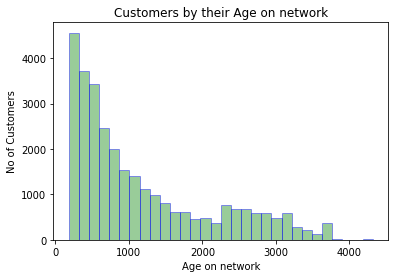

In [20]:
"""Analysing Customers for the time they have been with the Telecom provider
   Using AON = Age on network - number of days the customer is using the operator T network
"""
ax = sb.distplot(main_cust_churn['aon'], hist=True, kde=False, 
                 bins=30, color = 'green', 
                 hist_kws={'edgecolor':'blue'},)
ax.set_ylabel('No of Customers')
ax.set_xlabel('Age on network')
ax.set_title('Customers by their Age on network')

In [21]:
"""Sampling the above data to get meaningful insight to the loyal users"""
"""Categorical segmentation of data based on Age on network"""
days_duration = [0, 180, 360, 720, 1800, 1801]
days_sample = [ '0-180 Days', '180-360 Days', '360-720 Days', '720-1800 Days', '1800 Days and above']
main_cust_churn['day_range'] = pd.cut(main_cust_churn['aon'], days_duration, labels=days_sample)
print(main_cust_churn['day_range'].head())

0    720-1800 Days
1    720-1800 Days
4    720-1800 Days
8     180-360 Days
9    720-1800 Days
Name: day_range, dtype: category
Categories (5, object): [0-180 Days < 180-360 Days < 360-720 Days < 720-1800 Days < 1800 Days and above]


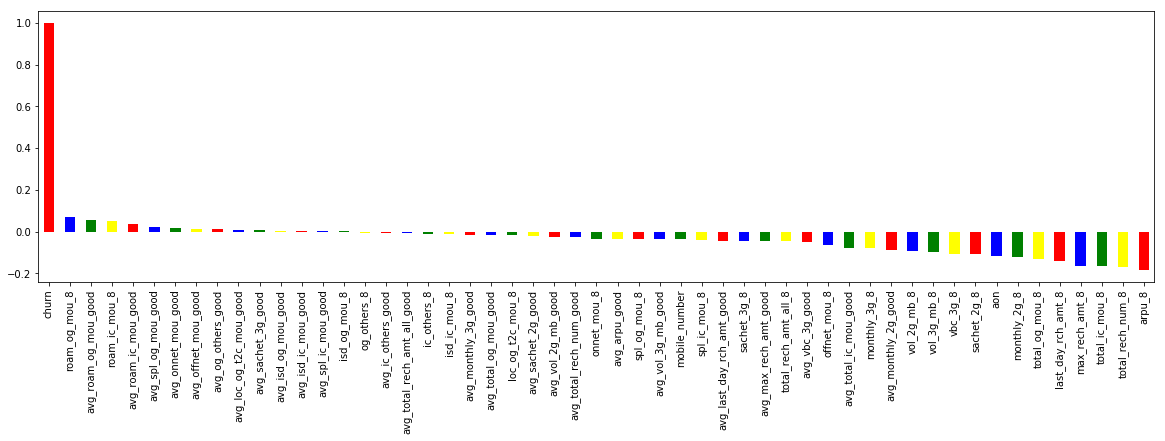

In [22]:

#Correlation of CHURN with other feature:
colors = ['red', 'blue', 'green', 'yellow']
plt.figure(figsize=(20,5))
main_cust_churn.corr()['churn'].sort_values(ascending = False).plot(kind='bar', color=tuple(colors))

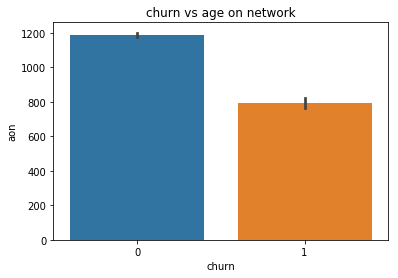

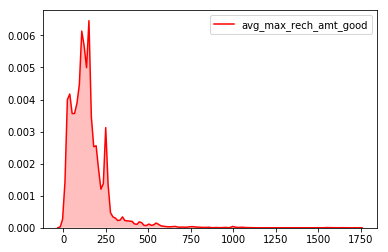

In [23]:
"""Plotting churn vs age on network"""
c_vs_aon = sb.barplot(x = main_cust_churn.churn, y = main_cust_churn.aon)
c_vs_aon.set_title('churn vs age on network')
plt.show()
"""Plotting churn vs avg recharge amount in good"""
c_vs_avg_rech = sb.kdeplot(main_cust_churn.avg_max_rech_amt_good[(main_cust_churn["churn"] == 0)],
                color="Red", shade = True)
c_vs_avg_rech = sb.kdeplot(main_cust_churn.avg_max_rech_amt_good[(main_cust_churn["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
c_vs_avg_rech.legend(["Not Churn","Churn"])
c_vs_avg_rech.set_title('churn vs avg recharge amount in good')
plt.show()

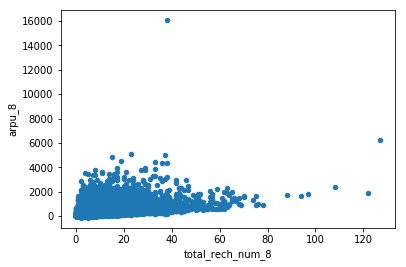

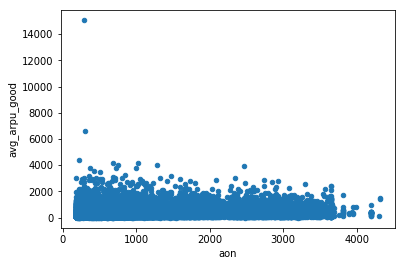

In [24]:
"""As we can see form the below plot, the customers who do not churn, 
they tend to stay for a longer time with the telecom provider."""
"""Now since we got the Good part of the correlation with churn of the 54 variables"""
"""Avg STD Outgoing Calls for Month 6 & 7, Outgoing calls in Roaming seems to be positively correlated with Churn"""
"""Now lets analyse the Active phase of 8th Month"""
main_cust_churn[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',
                                                              y='arpu_8')

main_cust_churn[['aon', 'avg_arpu_good']].plot.scatter(x = 'aon',
                                                              y='avg_arpu_good')

In [25]:
"""Before starting the modeling"""
"""Lets look at out final dataset"""
main_cust_churn.head(2)

"""Final cleaning of data"""
main_cust_churn.drop(['day_range','mobile_number'], axis=1, inplace=True)
main_cust_churn.fillna(0, inplace=True)
main_cust_churn.head(5)

for col in main_cust_churn.columns:
    main_cust_churn[col] = pd.to_numeric(main_cust_churn[col], errors='coerce')

In [26]:
"""Dataset Preparation"""
"""Let X be the feature dataset"""
"""Let Y be the predicting dataset"""
X = main_cust_churn.drop(['churn'], axis=1)
Y = main_cust_churn['churn']

main_cust_churn.drop('churn', axis=1, inplace=True)

In [27]:
"""Importing scikit learn module and related classes for prediction"""
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [28]:
"""Prepare Training and Testing Data"""
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=1)
X_train.shape, X_test.shape

((24000, 52), (6000, 52))

In [29]:
"""Predictive Models"""
"""We will be using 3 supervised learning algorithm to do Predictive Modeling"""
"""Linear Regression
   Logistic Regression with RFE and PCA
   SVM
   k-NN
"""

"""Linear Regression Model"""
linear_regressor = LinearRegression()
linear_regressor.fit(X_train,y_train)
y_pred = linear_regressor.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred.round())
print(confusion_matrix)
print(metrics.classification_report(y_test,y_pred.round()))  
print('Accuracy of Linear Regression Model: ',linear_regressor.score(X_test, y_test.round()))

[[   0    0    0]
 [   2 5468   60]
 [   0  378   92]]
             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00         0
        0.0       0.94      0.99      0.96      5530
        1.0       0.61      0.20      0.30       470

avg / total       0.91      0.93      0.91      6000

Accuracy of Linear Regression Model:  0.187306445031


E:\Users\Kurtesy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [30]:
"""Logistic Regression Model"""
logistic_regressor = LogisticRegression()
logistic_regressor.fit(X_train,y_train)
y_pred = logistic_regressor.predict(X_test).round()
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(metrics.classification_report(y_test,y_pred))  
print('Accuracy of Logistic Regression Model: ',logistic_regressor.score(X_test, y_test))

[[5450   80]
 [ 332  138]]
             precision    recall  f1-score   support

          0       0.94      0.99      0.96      5530
          1       0.63      0.29      0.40       470

avg / total       0.92      0.93      0.92      6000

Accuracy of Logistic Regression Model:  0.931333333333


In [ ]:
"""SVM Modeling"""
sv_regressor = SVC(kernel='linear') 
sv_regressor.fit(X_train,y_train)
y_pred = sv_regressor.predict(X_test).round()
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(metrics.classification_report(y_test,y_pred)) 
print('Accuracy of SVM Model: ',metrics.accuracy_score(y_test, y_pred))

In [33]:
"""K-NN Modeling"""
knn_regressor = KNeighborsClassifier(n_neighbors=3)
knn_regressor.fit(X_train,y_train)
y_pred = knn_regressor.predict(X_test).round()
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(metrics.classification_report(y_test,y_pred))  
print('Accuracy of KNN Regression Model: ',knn_regressor.score(X_test, y_test))

[[5347  183]
 [ 290  180]]
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      5530
          1       0.50      0.38      0.43       470

avg / total       0.91      0.92      0.92      6000

Accuracy of KNN Regression Model:  0.921166666667


In [34]:
"""Performing PCA"""
from sklearn.decomposition import PCA
pca = PCA(random_state=100)

#PCA on the train data
pca.fit(X_train)
X_train_pca = pca.fit_transform(X_train)
print(X_train_pca.shape)

X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

(24000, 52)
(6000, 52)


In [35]:
"""Applying Logistic Regression with PCA"""
logistic_regressor_pca = LogisticRegression(C=1e9)
logistic_regressor_pca.fit(X_train_pca, y_train)
y_pred = logistic_regressor_pca.predict(X_test_pca).round()
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(metrics.classification_report(y_test,y_pred)) 
print('Accuracy of Logistic Regression Model with PCA: ',metrics.accuracy_score(y_test,y_pred))

[[5448   82]
 [ 329  141]]
             precision    recall  f1-score   support

          0       0.94      0.99      0.96      5530
          1       0.63      0.30      0.41       470

avg / total       0.92      0.93      0.92      6000

Accuracy of Logistic Regression Model with PCA:  0.9315


[  13.74   22.8    29.89   34.7    39.33   43.69   47.83   51.64   54.87
   57.62   60.27   62.74   65.17   67.52   69.84   72.03   73.95   75.7
   77.43   79.06   80.67   82.09   83.46   84.8    86.07   87.29   88.42
   89.53   90.58   91.56   92.43   93.18   93.87   94.53   95.08   95.61
   96.13   96.61   97.08   97.53   97.94   98.33   98.71   99.     99.27
   99.52   99.7    99.84   99.97  100.03  100.04  100.04]
              Feature       PC1       PC2       PC3
0  avg_sachet_2g_good  0.328221 -0.031872 -0.007625
1  avg_sachet_2g_good  0.177602 -0.184875 -0.095522
2  avg_sachet_2g_good  0.232097 -0.153636 -0.111322
3  avg_sachet_2g_good  0.068550 -0.004628 -0.061096
4  avg_sachet_2g_good  0.092306 -0.026990 -0.066868
5  avg_sachet_2g_good  0.041178 -0.097480  0.035769
6  avg_sachet_2g_good  0.089645 -0.022206 -0.040061
7  avg_sachet_2g_good  0.067406 -0.145474  0.043253
8  avg_sachet_2g_good  0.003241 -0.004225  0.003285
9  avg_sachet_2g_good  0.254480 -0.215873 -0.124619


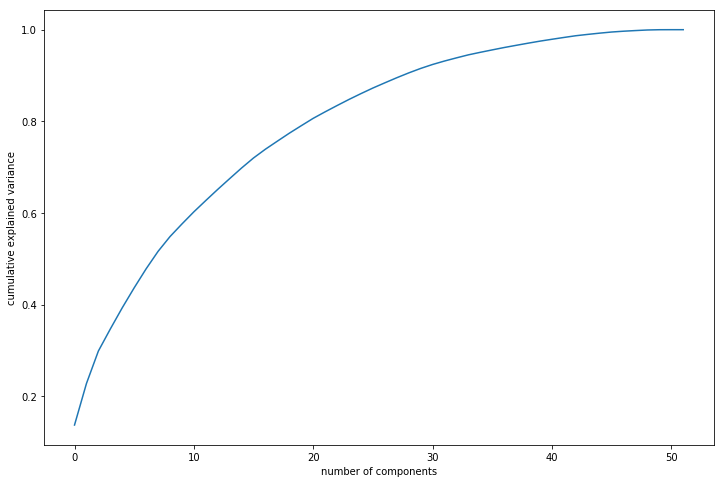

In [36]:
"""Model has 93.15% Accuracy with PCA"""
"""Analysing the major PCA features"""
df_pca =pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
print(df_pca.head(10))

fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [37]:
"""PCA for 32 features with threshold of 0.9"""
pca_32 = PCA(n_components=32)

df_train_pca_32 = pca_32.fit_transform(X_train)
print(df_train_pca_32.shape)

df_test_pca_32 = pca_32.transform(X_test)
print(df_test_pca_32.shape)

(24000, 32)
(6000, 32)


In [38]:
"""Applying Logistic Regression with PCA"""
logistic_regressor_pca_32 = LogisticRegression(C=1e9)
logistic_regressor_pca_32.fit(df_train_pca_32, y_train)
y_pred = logistic_regressor_pca_32.predict(df_test_pca_32).round()
print(df_train_pca_32.shape, y_pred.shape, y_test.shape)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(metrics.classification_report(y_test,y_pred)) 
print('Accuracy of Logistic Regression Model with PCA using 32 features: ',metrics.accuracy_score(y_test,y_pred))

(24000, 32) (6000,) (6000,)
[[5446   84]
 [ 352  118]]
             precision    recall  f1-score   support

          0       0.94      0.98      0.96      5530
          1       0.58      0.25      0.35       470

avg / total       0.91      0.93      0.91      6000

Accuracy of Logistic Regression Model with PCA using 32 features:  0.927333333333


In [ ]:
"""Model Evaluation and Comparision"""
from sklearn import model_selection
models = []
models = [#('LinR', linear_regressor),
          ('LogR', logistic_regressor), 
          ('SVN', sv_regressor()),
          ('KNN', knn_regressor),
          ('LogRPCA', logistic_regressor_pca),
          ('LogRPCA32', logistic_regressor_pca_32)]
              
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()